**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Robin BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**10 Dec 2024**

---
## Table of Contents<a id = "toc"></a>
* [Problem](#Problem)
  + [Objectives](#Obj)
  + [Data](#Data)
  + [Domain](#Domain) 
* [Test Two](#test)
  + [Results](#Results) 
---

### [Objective](#toc)<a id = "Data"><br> 

+ Solve a 1-D heat conduction problem with constant thermal conductivity, constant source and specified temperatures at the boundaries.

### [Problem Data](#toc)<a id = 'Data'></a>

> a = 0 cm <br>
> b = 5 cm <br>
> u(a) = 20 C <br>
> u(b) = 40 C <br>
> k = xx W/(mK) <br>
> f = 206151 W/m^2 

### [Domain](#toc)<a id = "Domain"></a>

In [8]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=0
x_max=0.05

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [9]:
'''Domain partition'''
from pyfires import get_domain_partition
'''Parent mapping'''
from pyfires import get_parent_mapping
'''The basis functions'''
from pyfires import get_parent_basis_functions
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function
'''All global basis functions'''
from pyfires import get_global_basis_functions
'''Inner product'''
from pyfires import inner_product

In [10]:
'''FEM Solution'''
'''Domain partition'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='flux', bc_x_max='flux')
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

## [Implementing Data](#toc)<a id = "test"></a>

Test two constraints the system with a constant thermal conductivity and a constant heat source using a Robin boundary condition. The goal of simulating the domain with these conditions is to produce a graphical solution on how heat is transfered throughout the domain. 

In [13]:
'''Parameters'''
htc = 10      #Heat transfer coefficient

In [14]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (156.0, 156.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (206151.0, 212621.0)) # W/m^3

view_plots = False

In [15]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [16]:
'''Building the lift function'''
u_a = 20 #temperature at point a in degrees C
u_b = 40 #temperature at point b in degrees C

lift_func = linear_func(x_min, x_max, (u_a, u_b)) # C
lift_prime = (u_b-u_a)/(x_max-x_min)
lift_func_prime = linear_func(x_min, x_max, (lift_prime, lift_prime)) # C

view_plots = False

In [17]:
if view_plots:
    n_plot_pts = 200
    title = 'Lift Function'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'T [C]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Lift Function Prime'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'dT/dx [C/m]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [18]:
'''Build FEM A Matrix'''
from pyfires import build_a_mtrx
a_mtrx = build_a_mtrx(phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem)

# A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches) + h*phi_i(x_min)*phi_j(x_min) + h*phi_i(x_max)*phi_j(x_max)

In [19]:
'''Build load vector'''
from pyfires import build_b_vec_2

b_vec_2 = build_b_vec_2(phi_list, phi_prime_list,k_func, f_func, lift_func_prime, domain_partition, x_min, x_max, n_elem, htc, u_a, u_b)

### [Results](#toc)<a id = "Results"></a>

In [21]:
'''Solution'''
'''Compute optimal coefficient vector'''
import numpy as np

c_star_vec = np.linalg.solve(a_mtrx, b_vec_2)

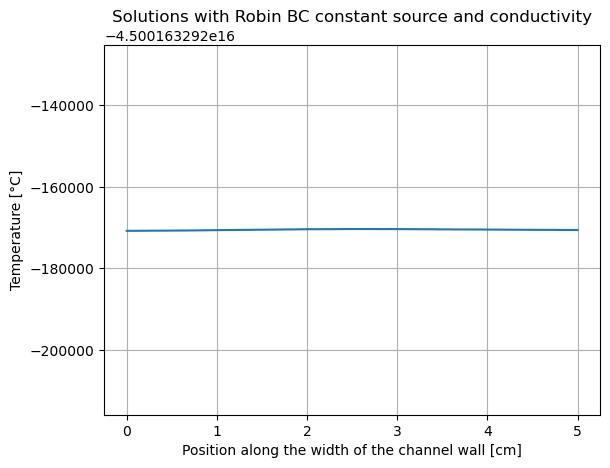

In [22]:
from pyfires import u_star

plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Robin BC constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]')

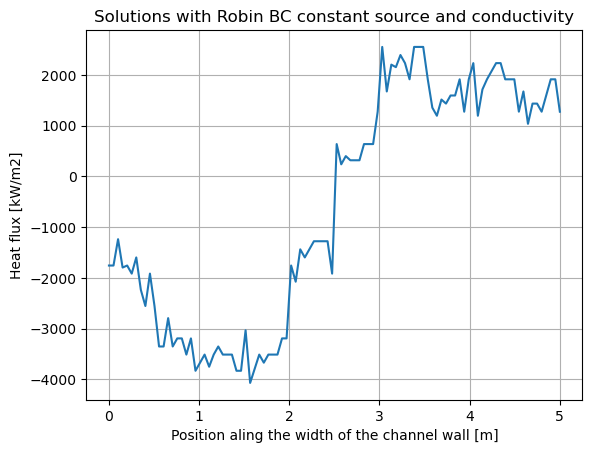

In [23]:
from pyfires import u_star_prime
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Robin BC constant source and conductivity', 
          xlabel='Position aling the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]')

In [24]:
'''Normal heat flux at boundaries'''
n_x_a = -1.0
n_x_b =  1.0
print('q_n(a) = ', q_x(x_min) * n_x_a)  
print('q_n(b) = ', q_x(x_max) * n_x_b)

q_n(a) =  [1757184.]
q_n(b) =  [1277952.]


In [25]:
'''Solution'''
'''Compute optimal coefficient vector'''
c_star_vec = np.linalg.solve(A_mtrx, b_vec)

'''Plot comparison of f and g_best_vec'''
from pyfires import u_star()
from pyfires import u_star_prime()

'''
def u_star(x):
    g_x=temp_func(x)
    for (j,phi_i) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[j])*phi_i(x)
    return g_x
    
def u_star_prime(x):
    g_x=slope_func(x)
    for j in range(len(phi_list)):
        g_x=g_x+(c_star_vec[j])*((2/h_e)*phi_prime_list[j](x))
    return g_x
'''

#Plotting the solutions 
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),u_star(np.linspace(x_min,x_max,2000)),label='Rayleigh-Ritz solution')
plt.title('Solutions with Robin BC, constant source and conductivity')
plt.xlabel("Position aling the width of the channel wall [m]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()

#print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min)[0])
#print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))
print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max)[0])

#Plotting the flux
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),-k_cond(np.linspace(x_min,x_max,2000))*u_star_prime((np.linspace(x_min,x_max,2000))),label='Rayleigh Ritz solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("Heat flux [W/m2]")
plt.legend()
plt.grid()
plt.show()

#Flux at the boundaries 
print("Flux at the boundaries:") 
print('q_na computed = ', -k_cond(x_min)*u_star_prime(x_min))
print('q_nb computed = ', -k_cond(x_max)*u_star_prime(x_max))
print('flux error [%]= ',(-k_cond(x_max)*u_star_prime(x_max) - u_b)/u_b*100)

SyntaxError: invalid syntax (465839815.py, line 6)